In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from pprint import pp

from utils import CONFIG

In [74]:
top_k = 50

drop_columns = [
    "device",
    "learning_rate",
    "batch_size",
    "top_k",
    "seed",
    "epochs",
    "datasets",
    "log"
]

if False:
    for k in CONFIG.top_k:
        if k != top_k:
            drop_columns.extend([f"Precision@{k}", f"Recall@{k}", f"NDCG@{k}"])

print(drop_columns)

['device', 'learning_rate', 'batch_size', 'top_k', 'seed', 'epochs', 'datasets', 'log']


In [75]:
files = os.listdir("logs")
settings = {}

for fname in files:
    with open(f"logs/{fname}", "r", encoding="utf-8") as fin:
        lines = list(fin)
        epochs, train_loss, *res = lines[-1].strip().split("\t")

        d = json.loads(lines[0])

        d["Epochs"] = int(epochs)
        d["Loss"] = float(train_loss)

        for i, k in enumerate(CONFIG.top_k):
            precision, recall, ndcg = res[i * 3:(i * 3)+3]
            d[f"Precision@{k}"] = float(precision)
            d[f"Recall@{k}"] = float(recall)
            d[f"NDCG@{k}"] = float(ndcg)

        settings[fname[:-4]] = d

df = pd.DataFrame(settings).T.convert_dtypes()
df = df.drop(columns=drop_columns)

df

,dataset,early_stop_window,early_stop_threshold,n_layers,embedding_dim,fusion_type,fusion_modalities,autoencoder,multimodal,single_branch,...,NDCG@5,Precision@10,Recall@10,NDCG@10,Precision@20,Recall@20,NDCG@20,Precision@50,Recall@50,NDCG@50
2025-01-20T19:18:22,dbbook,20,0.000001,2,256,early,mean,False,False,False,...,0.0478,0.0713,0.0482,0.0745,0.0732,0.0362,0.1119,0.0877,0.024,0.181
2025-01-19T20:21:43,dbbook,50,0.03,2,1024,early,prod,False,True,False,...,0.0726,0.0498,0.0765,0.0747,0.0389,0.1156,0.0908,0.0274,0.1993,0.1215
2025-01-19T21:39:15,dbbook,20,0.000001,4,256,early,mean,False,False,False,...,0.0801,0.0557,0.0871,0.084,0.042,0.1284,0.1005,0.0284,0.2153,0.1316
2025-01-19T21:28:46,dbbook,70,0.000001,4,256,early,mean,False,False,False,...,0.0816,0.0565,0.0883,0.085,0.0426,0.1311,0.1021,0.0282,0.216,0.1323
2025-01-19T20:32:45,dbbook,50,0.001,0,1024,early,prod,False,True,False,...,0.0886,0.0578,0.09,0.0897,0.0433,0.1316,0.1063,0.0288,0.2174,0.137
2025-01-20T17:25:29,dbbook,20,0.000001,2,256,early,mean,False,False,False,...,0.0857,0.0565,0.0897,0.0879,0.0424,0.1305,0.1043,0.0274,0.2092,0.1325
2025-01-20T19:15:51,ml1m,20,0.000001,2,256,early,mean,False,False,False,...,0.0917,0.2291,0.1891,0.155,0.2295,0.1599,0.2485,0.246,0.1179,0.4175
2025-01-19T20:48:56,dbbook,70,0.01,0,1024,early,prod,False,True,False,...,0.0886,0.0578,0.09,0.0897,0.0433,0.1316,0.1063,0.0288,0.2174,0.137
2025-01-20T16:56:19,dbbook,20,0.000001,2,256,early,mean,False,False,False,...,0.0842,0.0551,0.087,0.086,0.0414,0.1283,0.1024,0.027,0.2064,0.1305
2025-01-20T19:27:45,dbbook,20,0.000001,4,256,early,mean,False,True,False,...,0.0466,0.0719,0.0483,0.072,0.0725,0.0363,0.1073,0.0863,0.0254,0.186


In [76]:
df.where(
    (df["embedding_dim"] == 256) & (df["dataset"] == "dbbook") & (df["fusion_modalities"] == "max")
).groupby(
    ["bidirectional", "multimodal", "n_layers"]
)[["Precision@50", "Recall@50", "NDCG@50", "Loss", "Epochs"]].mean()

,,,Precision@50,Recall@50,NDCG@50,Loss,Epochs
bidirectional,multimodal,n_layers,,,,,


In [77]:
df.rename(columns={"embedding_dim": "emb_dim", "fusion_modalities": "fusion"}).where(df["multimodal"] == False).groupby("n_layers")[["Precision@10", "Recall@10", "NDCG@10"]].mean()

,Precision@10,Recall@10,NDCG@10
n_layers,,,
2,0.120657,0.114586,0.102943
4,0.0559,0.087467,0.0844


In [78]:
file = list(sorted(os.listdir("logs")))[-1]
file_path = f"logs/{file}"

with open(file_path, 'r') as f:
    config_line = f.readline().strip()
    config = json.loads(config_line)

data = pd.read_csv(file_path, sep='\t', skiprows=1)

In [79]:
data

,Epoch,T-Loss,V-Loss,Precision@5,Recall@5,NDCG@5,Precision@10,Recall@10,NDCG@10,Precision@20,Recall@20,NDCG@20,Precision@50,Recall@50,NDCG@50
0,1,0.6904,0.6788,0.0268,0.0212,0.0323,0.0207,0.0319,0.0325,0.0154,0.0466,0.0384,0.0103,0.0760,0.0492
1,2,0.4935,0.5712,0.0447,0.0346,0.0512,0.0359,0.0532,0.0524,0.0280,0.0814,0.0639,0.0199,0.1451,0.0869
2,3,0.1991,0.4855,0.0467,0.0357,0.0543,0.0379,0.0560,0.0558,0.0308,0.0894,0.0695,0.0218,0.1598,0.0949
3,4,0.1022,0.4850,0.0470,0.0364,0.0545,0.0385,0.0574,0.0566,0.0312,0.0924,0.0707,0.0221,0.1620,0.0961
4,5,0.0885,0.4881,0.0472,0.0368,0.0553,0.0393,0.0595,0.0582,0.0311,0.0928,0.0715,0.0220,0.1616,0.0968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,0.0789,0.4830,0.0493,0.0379,0.0556,0.0407,0.0629,0.0592,0.0324,0.0986,0.0736,0.0223,0.1663,0.0983
496,497,0.0800,0.4893,0.0477,0.0370,0.0541,0.0393,0.0606,0.0573,0.0321,0.0970,0.0722,0.0223,0.1659,0.0972
497,498,0.0786,0.4875,0.0471,0.0369,0.0533,0.0389,0.0597,0.0564,0.0318,0.0962,0.0713,0.0222,0.1658,0.0965
498,499,0.0782,0.4869,0.0463,0.0365,0.0529,0.0393,0.0609,0.0570,0.0320,0.0974,0.0719,0.0223,0.1662,0.0969


In [80]:
epochs = data["Epoch"]
train_loss = data["T-Loss"]
val_loss = data["V-Loss"]

{'device': 'cuda:0',
 'batch_size': 2048,
 'learning_rate': 0.1,
 'dataset': 'dbbook',
 'epochs': 500,
 'top_k': [5,
           10,
           20,
           50],
 'seed': 19,
 'early_stop_window': 20,
 'early_stop_threshold': 1e-06,
 'log': True,
 'n_layers': 4,
 'embedding_dim': 256,
 'fusion_type': 'early',
 'fusion_modalities': 'mean',
 'autoencoder': False,
 'multimodal': True,
 'single_branch': False,
 'bidirectional': False,
 'freeze': True,
 'ensemble_fusion': False,
 'datasets': {'dbbook': ['images',
                         'text'],
              'ml1m': ['audio',
                       'images',
                       'text',
                       'video']}}

Epoch           500.0000
T-Loss            0.0783
V-Loss            0.4853
Precision@5       0.0471
Recall@5          0.0372
NDCG@5            0.0537
Precision@10      0.0397
Recall@10         0.0611
NDCG@10           0.0575
Precision@20      0.0322
Recall@20         0.0980
NDCG@20           0.0725
Precision@50      0.

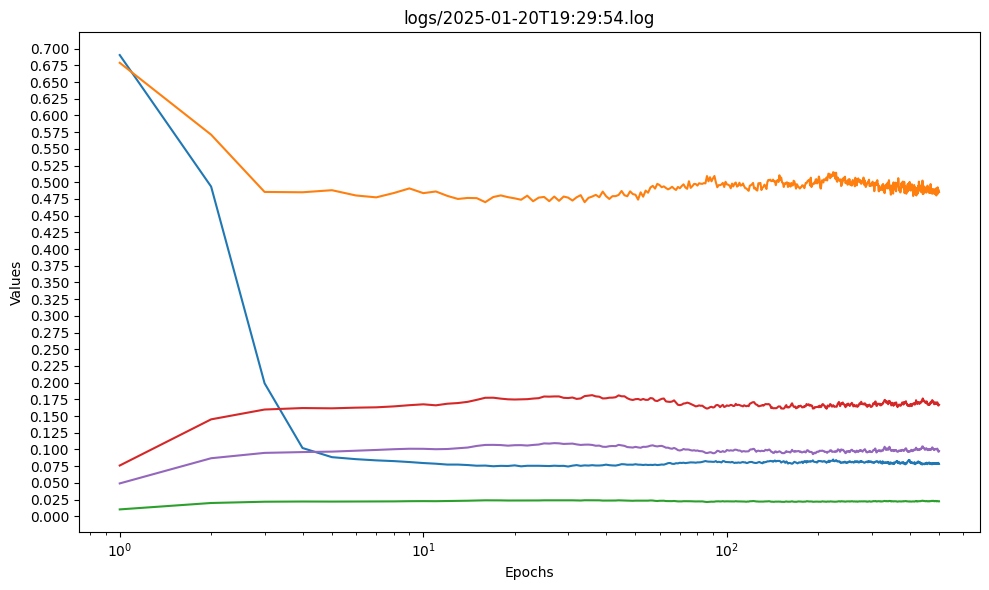

In [81]:
pp(config, width=1)
print()
print(data.iloc[-1])

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_loss, label="T-Loss")
plt.plot(epochs, val_loss, label="V-Loss")

for k in [50]:
    plt.plot(epochs, data[f"Precision@{k}"], label=f"Precision@{k}")
    plt.plot(epochs, data[f"Recall@{k}"], label=f"Recall@{k}")
    plt.plot(epochs, data[f"NDCG@{k}"], label=f"NDCG@{k}")


plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title(file_path)
#plt.legend()

plt.gca().yaxis.set_major_locator(plt.MaxNLocator(nbins=30))
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=20))
#plt.xscale("log")

plt.tight_layout()
plt.show()